# BTB-EDA: Veri Keşif ve Analiz Notebook
## Başlangıç Şablonu

Bu notebook BTB (Baseball-Tennis-Basketball) gibi spor verileri üzerinde exploratory data analysis (EDA) yapmak için kullanılabilir.

## 1. Kütüphaneleri Yükle

In [1]:
%pip install pandas numpy matplotlib scipy seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Tüm kütüphaneler başarıyla yüklendi!")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Tüm kütüphaneler başarıyla yüklendi!
✅ Tüm kütüphaneler başarıyla yüklendi!


## 2. Veri Yükleme

In [2]:
"""
HÜCRE 2: BTB VERİ DOSYALARINI YÜKLEME VE İNCELEME
================================================
Bu hücre:
- BTB-data klasöründeki closing_odds.csv.gz dosyasını yükler
- Dosyanın içeriğini ve yapısını inceler
- Veri hakkında özet bilgi sunar

BTB-data klasörü içeriği:
1. closing_odds.csv.gz - Kapanış oranları ✓ (KULLANILIYOR)
2. odds_series.csv.gz - Odds serileri (birincil)
3. odds_series_b.csv.gz - Odds serileri (alternatif)
4. odds_series_b_matches.csv.gz - Odds serileri B maç verileri
5. odds_series_matches.csv.gz - Odds serileri maç verileri
"""

import os
import pandas as pd

data_dir = '/Users/boraberkercansever/Desktop/DSA210/raw/BTB-data'

# Yüklenecek dosya
selected_file = 'closing_odds.csv.gz'
file_path = os.path.join(data_dir, selected_file)

print("="*80)
print("Beat the Bookie - Closing Odds Load")
print("="*80)
print(f"\n📂 {selected_file}")
file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
print(f"   File Size: {file_size:.2f} MB")
print("-"*80)

data_files = {}

try:
    # CSV.GZ dosyasını doğrudan pandas'e yükle
    df = pd.read_csv(file_path)
    data_files['closing_odds'] = df
    
    print(f"✅ Loaded")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Data Types:\n{df.dtypes}")
    print(f"\n   First 3 rows:")
    display(df.head(3))
    
    print(f"\n   Missing Values:")
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print(null_counts[null_counts > 0])
    else:
        print("   No missing values! ✓")
        
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*80)
print("Summary")
print("="*80)
print(f"Loaded DataFrames: {list(data_files.keys())}")

Beat the Bookie - Closing Odds Load

📂 closing_odds.csv.gz
   File Size: 18.56 MB
--------------------------------------------------------------------------------
✅ Loaded
   Shape: 479,440 rows × 19 columns
   Columns: ['match_id', 'league', 'match_date', 'home_team', 'home_score', 'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win', 'top_bookie_home_win', 'top_bookie_draw', 'top_bookie_away_win', 'n_odds_home_win', 'n_odds_draw', 'n_odds_away_win']
   Data Types:
match_id                 int64
league                  object
match_date              object
home_team               object
home_score               int64
away_team               object
away_score               int64
avg_odds_home_win      float64
avg_odds_draw          float64
avg_odds_away_win      float64
max_odds_home_win      float64
max_odds_draw          float64
max_odds_away_win      float64
top_bookie_home_win     object
top_

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9



   Missing Values:
top_bookie_home_win    28
top_bookie_away_win    24
dtype: int64

Summary
Loaded DataFrames: ['closing_odds']


In [3]:
"""
HÜCRE 2B: BTB VERİSİNİ 2012-2015 SEZONLARINA VE 5 BÜYÜK LİGE FİLTRELE
===================================================================
Bu hücre:
- closing_odds verisini 2012-2015 sezonlarına sınırlanır
- Mevcut 4 ligde (İngiltere, Fransa, Almanya, İtalya) ile filtreler
  NOT: Spain: La Liga BTB datasında mevcut değil
- df_group1 ile eşleştirmeye hazır hale getirir
"""

import pandas as pd

# match_date'yi datetime'a çevir
df['match_date'] = pd.to_datetime(df['match_date'])

# 2012-2015 sezonlarını filtrele (2012-08-01 ile 2015-06-30)
df_filtered = df[(df['match_date'] >= '2012-08-01') & (df['match_date'] <= '2015-06-30')].copy()

print("="*80)
print("Beat the Bookie Data Filteration: 2012-2015 SEASONS")
print("="*80)
print(f"\nOriginal data: {len(df):,} rows")
print(f"Filtered data (2012-2015): {len(df_filtered):,} rows")

# Show available leagues
print("\n" + "="*80)
print("AVAILABLE LEAGUES (2012-2015)")
print("="*80)
print("\nLeague distribution:")
print(df_filtered['league'].value_counts())

# 5 büyük lig tanımla (BTB'deki lig isimleri ile)
# NOT: Spain: La Liga, BTB'de "Spain: Primera Division" olarak adlandırılmıştır
big_five_leagues = [
    'England: Premier League',
    'France: Ligue 1',
    'Germany: Bundesliga',
    'Italy: Serie A',
    'Spain: Primera Division'  # La Liga
]

# BTB datasında mevcut olanları filtrele
df_big_five = df_filtered[df_filtered['league'].isin(big_five_leagues)].copy()

print(f"\nBIG FIVE LEAGUES FILTERATION")
print("="*80)
print(f"Before big five leagues: {len(df_filtered):,} rows")
print(f"After big five leagues: {len(df_big_five):,} rows")

print("\nBig five leagues distribution (BTB data):")
lig_count = df_big_five['league'].value_counts()
print(lig_count)

print("\nSeason distribution:")
df_big_five['season_year'] = df_big_five['match_date'].dt.year
print(df_big_five.groupby(['league', 'season_year']).size().unstack(fill_value=0))

# Football verisi ile karşılaştırma
print("\n" + "="*80)
print("BTB vs FOOTBALL DATA COMPARISON")
print("="*80)
print("\n✅ 5 BIG FIVE LEAGUES ALL AVAILABLE!")
print(f"Compatible data in BTB: {lig_count.sum():,} rows")

print(f"\n✅ BTB data successfully filtered for 2012-2015 seasons and big five leagues")
print(f"Variable to use: df_big_five")

Beat the Bookie Data Filteration: 2012-2015 SEASONS

Original data: 479,440 rows
Filtered data (2012-2015): 204,927 rows

AVAILABLE LEAGUES (2012-2015)

League distribution:
league
World: Club Friendly                   6784
World: Friendly International          2021
England: League One                    1671
England: League Two                    1671
England: Championship                  1671
                                       ... 
San Marino: Super Cup                     1
Switzerland: 1.Liga Classic Group 1       1
Africa: CECAFA Clubs Cup                  1
Northern Ireland: Charity Shield          1
Côte d'Ivoire: Ligue 1                    1
Name: count, Length: 694, dtype: int64

BIG FIVE LEAGUES FILTERATION
Before big five leagues: 204,927 rows
After big five leagues: 5,450 rows

Big five leagues distribution (BTB data):
league
England: Premier League    1140
Spain: Primera Division    1140
France: Ligue 1            1139
Italy: Serie A             1139
Germany: Bundes

In [4]:
"""
HÜCRE 3: CLOSING ODDS HAZIRLANMASI
==================================
Bu hücre:
- BTB verisi (df_big_five) closing odds'ı hazırlar
- Tarih ve takım adlarını normalize eder
- FBD verisi ile merge için hazırlanır
"""

# Kapanış odds sütunları (Average Odds)
closing_odds_cols = ['home_team', 'away_team', 'match_date', 
                     'avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win',
                     'league']

# df_big_five'den gerekli sütunları seç
df_btb_odds = df_big_five[closing_odds_cols].copy()

# Sütun adlarını standartlaştır
df_btb_odds.columns = ['HomeTeam', 'AwayTeam', 'Date', 
                       'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 
                       'league']

# Tarih formatı datetime olmalı
df_btb_odds['Date'] = pd.to_datetime(df_btb_odds['Date'])

print("="*80)
print("Beat the Bookie - Closing Odds Preparation")
print("="*80)
print(f"\nClosing odds data to be used: {len(df_btb_odds):,} rows")
print(f"\nColumns: {list(df_btb_odds.columns)}")

# Check for missing values
print(f"\nMissing values in closing odds columns:")
null_info = df_btb_odds[['AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close']].isnull().sum()
print(null_info)

if null_info.sum() > 0:
    # Eksik closing odds'ları sil
    df_btb_odds = df_btb_odds.dropna(subset=['AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close'])
    print(f"\nEksik closing odds'lar silindikten sonra: {len(df_btb_odds):,} satır")

# İlk örnek
print(f"\nFirst 3 examples (BTB - Closing Odds):")
display(df_btb_odds.head(3))

print(f"\n✅ BTB closing odds data prepared")
print(f"Variable to be used: df_btb_odds")

Beat the Bookie - Closing Odds Preparation

Closing odds data to be used: 5,450 rows

Columns: ['HomeTeam', 'AwayTeam', 'Date', 'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 'league']

Missing values in closing odds columns:
AVG_H_Close    0
AVG_D_Close    0
AVG_A_Close    0
dtype: int64

First 3 examples (BTB - Closing Odds):


,HomeTeam,AwayTeam,Date,AVG_H_Close,AVG_D_Close,AVG_A_Close,league
276051,Montpellier,Toulouse,2012-08-10,2.0158,3.1042,3.9575,France: Ligue 1
276340,Evian TG,Bordeaux,2012-08-11,2.9128,3.0660,2.4928,France: Ligue 1
276341,Nancy,Brest,2012-08-11,1.8888,3.1684,4.4416,France: Ligue 1



✅ BTB closing odds data prepared
Variable to be used: df_btb_odds


In [5]:
"""
HÜCRE 4: LINE MOVEMENT HESAPLAMA
================================
Bu hücre:
- Opening odds (FBD) ve closing odds (BTB) verisini eşleştirir
- Line movement hesaplayarak birleştirilmiş dataset oluşturur
- Hesaplamalar:
  * Line Movement Home = Closing Odds - Opening Odds (Home)
  * Line Movement Draw = Closing Odds - Opening Odds (Draw)
  * Line Movement Away = Closing Odds - Opening Odds (Away)
"""

# FBD opening odds'ını CSV'den yükle
import os
fbd_csv_path = '/Users/boraberkercansever/Desktop/DSA210/processed/fbd_opening_odds.csv'
df_fbd_odds = pd.read_csv(fbd_csv_path)
df_fbd_odds['Date'] = pd.to_datetime(df_fbd_odds['Date'])

# İki veriyi merge etmek için büyük harfleri normalize et
df_btb_odds_merge = df_btb_odds.copy()
df_btb_odds_merge['HomeTeam'] = df_btb_odds_merge['HomeTeam'].str.strip()
df_btb_odds_merge['AwayTeam'] = df_btb_odds_merge['AwayTeam'].str.strip()

print("="*80)
print("LINE MOVEMENT HESAPLAMA")
print("="*80)
print(f"\nOpening Odds (FBD): {len(df_fbd_odds):,} satır")
print(f"Closing Odds (BTB): {len(df_btb_odds_merge):,} satır")

# Merge işlemi: HomeTeam, AwayTeam, Date ve league'e göre
df_line_movement = pd.merge(
    df_fbd_odds,
    df_btb_odds_merge[['HomeTeam', 'AwayTeam', 'Date', 'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close', 'league']],
    on=['HomeTeam', 'AwayTeam', 'Date', 'league'],
    how='inner'
)

print(f"\nMerge sonrası başarıyla eşleştirilen maçlar: {len(df_line_movement):,} satır")

# Line Movement hesaplama
# Pozitif = odds artmış (bahisçi home/draw/away'in kazanma ihtimalini azaltmış)
# Negatif = odds düşmüş (bahisçi home/draw/away'in kazanma ihtimalini artırmış)
df_line_movement['LM_Home'] = df_line_movement['AVG_H_Close'] - df_line_movement['B365H']
df_line_movement['LM_Draw'] = df_line_movement['AVG_D_Close'] - df_line_movement['B365D']
df_line_movement['LM_Away'] = df_line_movement['AVG_A_Close'] - df_line_movement['B365A']

print(f"\nLine Movement İstatistikleri:")
print(f"\n{'Metrk':<20} {'Min':<10} {'Max':<10} {'Ortalama':<10} {'Std Dev':<10}")
print("-" * 60)
for col in ['LM_Home', 'LM_Draw', 'LM_Away']:
    print(f"{col:<20} {df_line_movement[col].min():<10.4f} {df_line_movement[col].max():<10.4f} "
          f"{df_line_movement[col].mean():<10.4f} {df_line_movement[col].std():<10.4f}")

# Lig bazında line movement
print(f"\nLig Bazında Ortalama Line Movement:")
print(df_line_movement.groupby('league')[['LM_Home', 'LM_Draw', 'LM_Away']].mean().round(4))

# İlk örnekler
print(f"\nİlk 3 örnek (Opening Odds, Closing Odds, Line Movement):")
cols_display = ['HomeTeam', 'AwayTeam', 'Date', 'league',
                'B365H', 'B365D', 'B365A',
                'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close',
                'LM_Home', 'LM_Draw', 'LM_Away']
display(df_line_movement[cols_display].head(3))

print(f"\n✅ Line movement hesaplaması tamamlandı")
print(f"Kullanılacak değişken: df_line_movement ({len(df_line_movement):,} maç)")


LINE MOVEMENT HESAPLAMA

Opening Odds (FBD): 5,478 satır
Closing Odds (BTB): 5,450 satır

Merge sonrası başarıyla eşleştirilen maçlar: 1,851 satır

Line Movement İstatistikleri:

Metrk                Min        Max        Ortalama   Std Dev   
------------------------------------------------------------
LM_Home              -1.4782    2.3200     -0.0002    0.2170    
LM_Draw              -1.7264    1.4819     0.0107     0.1523    
LM_Away              -7.7243    3.0003     -0.0124    0.4537    

Lig Bazında Ortalama Line Movement:
                         LM_Home  LM_Draw  LM_Away
league                                            
England: Premier League   0.0064   0.0179  -0.0243
France: Ligue 1          -0.0179   0.0035  -0.0512
Germany: Bundesliga      -0.0048   0.0369   0.0542
Italy: Serie A            0.0147   0.0038   0.0126

İlk 3 örnek (Opening Odds, Closing Odds, Line Movement):


,HomeTeam,AwayTeam,Date,league,B365H,B365D,B365A,AVG_H_Close,AVG_D_Close,AVG_A_Close,LM_Home,LM_Draw,LM_Away
0,Bayern Munich,Wolfsburg,2014-08-22,Germany: Bundesliga,1.2575,6.12750,10.43750,1.2579,6.0736,10.5161,0.0004,-0.05390,0.07860
1,Hoffenheim,Augsburg,2014-08-23,Germany: Bundesliga,1.9475,3.57250,3.75875,1.9179,3.5600,3.8629,-0.0296,-0.01250,0.10415
2,Paderborn,Mainz,2014-08-24,Germany: Bundesliga,2.9625,3.35375,2.36875,3.0182,3.3661,2.3196,0.0557,0.01235,-0.04915



✅ Line movement hesaplaması tamamlandı
Kullanılacak değişken: df_line_movement (1,851 maç)


In [8]:
"""
HÜCRE 5: EN ÇOK OYNANILAN MAÇLAR VE EN DÜŞÜK ORANLI TAKIM ANALİZİ
================================================================
Bu hücre:
- Line movement analiz ederek en çok oynanılan maçları belirler
- Her maçta en düşük oranı (favorite takımı) tanımlar
- Favorite takımın kazanıp kazanmadığını kontrol eder
- Sporcu manipülasyonu analizi için veri hazırlar

Analiz hedefi:
- Yüksek line movement'lı maçlarda favorite takım sonuçları
- Bahisçilerin davranışı vs gerçek sonuçlar karşılaştırması
"""

import pandas as pd
import numpy as np

print("="*100)
print("EN ÇOK OYNANILAN MAÇLAR VE FAVORITE TAKIM ANALİZİ")
print("="*100)

# 1. Line Movement Büyüklüğünü Hesapla (Absolute değerler)
# Line movement'ın toplam mutlak değeri = oyun yoğunluğunun göstergesi
df_line_movement['Total_LM'] = (
    abs(df_line_movement['LM_Home']) + 
    abs(df_line_movement['LM_Draw']) + 
    abs(df_line_movement['LM_Away'])
)

# 2. Her maçta en düşük closing odds'u (favorite takımı) belirle
df_analysis = df_line_movement.copy()

# Opening odds sütunları B365H, B365D, B365A'dır
df_analysis['Min_Close_Odds'] = df_analysis[['B365H', 'B365D', 'B365A']].min(axis=1)

# Favorite takımı belirle (en düşük odds'lu)
def identify_favorite(row):
    """En düşük opening odds'a sahip takımı/sonucu belirler"""
    if row['B365H'] == row['Min_Close_Odds']:
        return 'Home'
    elif row['B365A'] == row['Min_Close_Odds']:
        return 'Away'
    else:
        return 'Draw'

def get_favorite_odds(row):
    """Favorite takımın oranını döndür"""
    return row['Min_Close_Odds']

df_analysis['Favorite_Type'] = df_analysis.apply(identify_favorite, axis=1)
df_analysis['Favorite_Odds'] = df_analysis.apply(get_favorite_odds, axis=1)

# 3. Line Movement Kategorileri
# Yüksek movement = çok bahis aktivitesi
quantiles = df_analysis['Total_LM'].quantile([0.25, 0.5, 0.75])
print(f"\nLine Movement Dağılımı:")
print(f"  Q1 (25%): {quantiles[0.25]:.4f}")
print(f"  Q2 (50%): {quantiles[0.5]:.4f}")
print(f"  Q3 (75%): {quantiles[0.75]:.4f}")

def categorize_lm(total_lm):
    """Line movement'ı kategorize et"""
    if total_lm >= quantiles[0.75]:
        return 'Çok Yüksek'
    elif total_lm >= quantiles[0.5]:
        return 'Yüksek'
    elif total_lm >= quantiles[0.25]:
        return 'Orta'
    else:
        return 'Düşük'

df_analysis['LM_Category'] = df_analysis['Total_LM'].apply(categorize_lm)

# 4. En çok oynanılan maçları filtrele (Çok Yüksek + Yüksek)
high_lm_threshold = quantiles[0.5]  # Medyan
df_high_activity = df_analysis[df_analysis['Total_LM'] >= high_lm_threshold].copy()

print(f"\n📊 LİNE MOVEMENT KATEGORİSİ DAĞILIMI:")
print(f"{'-'*50}")
print(df_analysis['LM_Category'].value_counts().sort_index(ascending=False))

print(f"\n\n🎲 EN ÇOK OYNANILAN MAÇLAR (Medyan üzeri Line Movement):")
print(f"  Toplam maçlar: {len(df_analysis):,}")
print(f"  Yüksek aktivite maçları: {len(df_high_activity):,} ({len(df_high_activity)/len(df_analysis)*100:.1f}%)")

# 5. Favorite takımları belirle ve analiz et
print(f"\n\n⭐ FAVORITE TAKIM DAĞILIMI (Yüksek aktivite maçlarda):")
print(f"{'-'*50}")
favorite_dist = df_high_activity['Favorite_Type'].value_counts()
for fav_type, count in favorite_dist.items():
    percentage = count / len(df_high_activity) * 100
    print(f"  {fav_type:<10}: {count:>5} ({percentage:>5.1f}%)")

# 6. İlk 10 en yüksek LM'li maçı göster
print(f"\n\n🔥 EN YÜKSEK LINE MOVEMENT'LI 10 MAÇ:")
print(f"{'-'*100}")

top_10_lm = df_analysis.nlargest(10, 'Total_LM')[
    ['HomeTeam', 'AwayTeam', 'Date', 'league', 'Favorite_Type', 'Favorite_Odds', 'Total_LM']
].reset_index(drop=True)

for idx, row in top_10_lm.iterrows():
    fav_emoji = "🌟" if row['Favorite_Type'] in ['Home', 'Away'] else "🤝"
    print(f"{idx+1:2d}. {row['HomeTeam']:<20} vs {row['AwayTeam']:<20} | "
          f"{row['Date'].strftime('%d/%m/%Y')} | LM: {row['Total_LM']:.4f} | "
          f"Favorite: {fav_emoji} {row['Favorite_Type']} ({row['Favorite_Odds']:.2f})")

# 7. Lig bazında yüksek activity maçları
print(f"\n\n🏆 LİG BAZINDA YÜKSEK AKTİVİTE MAÇ SAYISI:")
print(f"{'-'*50}")
high_activity_by_league = df_high_activity['league'].value_counts().sort_values(ascending=False)
for league, count in high_activity_by_league.items():
    total_in_league = len(df_analysis[df_analysis['league'] == league])
    percentage = count / total_in_league * 100
    print(f"  {league:<30}: {count:>4} ({percentage:>5.1f}%)")

# 8. Hazırlanmış veri özeti
print(f"\n\n✅ ANALİZ VERİSİ HAZIRLANMIŞTIR:")
print(f"{'-'*50}")
print(f"  Değişken: df_analysis")
print(f"  Toplam maç: {len(df_analysis):,}")
print(f"  Yeni sütunlar:")
print(f"    - Total_LM: Toplam line movement")
print(f"    - Favorite_Type: Favorite takım (Home/Away/Draw)")
print(f"    - Favorite_Odds: Favorite oranı")
print(f"    - LM_Category: LM kategorisi")

print(f"\n  Yüksek aktivite veri: df_high_activity")
print(f"  Yüksek aktivite maç: {len(df_high_activity):,}")

# İlk 5 örnek
print(f"\n\n📋 İLK 5 MAÇ ÖRNEĞİ (Analiz verileri):")
display_cols_analysis = [
    'HomeTeam', 'AwayTeam', 'Date', 'league',
    'B365H', 'B365D', 'B365A',
    'Favorite_Type', 'Favorite_Odds', 'Total_LM', 'LM_Category'
]
display(df_analysis[display_cols_analysis].head(5))

print(f"\n✅ En çok oynanılan maçlar ve favorite takım analizi tamamlandı")

EN ÇOK OYNANILAN MAÇLAR VE FAVORITE TAKIM ANALİZİ

Line Movement Dağılımı:
  Q1 (25%): 0.1588
  Q2 (50%): 0.3138
  Q3 (75%): 0.6063

📊 LİNE MOVEMENT KATEGORİSİ DAĞILIMI:
--------------------------------------------------
LM_Category
Çok Yüksek    463
Yüksek        463
Orta          462
Düşük         463
Name: count, dtype: int64


🎲 EN ÇOK OYNANILAN MAÇLAR (Medyan üzeri Line Movement):
  Toplam maçlar: 1,851
  Yüksek aktivite maçları: 926 (50.0%)


⭐ FAVORITE TAKIM DAĞILIMI (Yüksek aktivite maçlarda):
--------------------------------------------------
  Home      :   683 ( 73.8%)
  Away      :   241 ( 26.0%)
  Draw      :     2 (  0.2%)


🔥 EN YÜKSEK LINE MOVEMENT'LI 10 MAÇ:
----------------------------------------------------------------------------------------------------
 1. Juventus             vs Atalanta             | 05/05/2014 | LM: 9.5959 | Favorite: 🌟 Home (1.17)
 2. Dortmund             vs Braunschweig         | 18/08/2013 | LM: 3.5492 | Favorite: 🌟 Home (1.16)
 3. Bayern Mu

,HomeTeam,AwayTeam,Date,league,B365H,B365D,B365A,Favorite_Type,Favorite_Odds,Total_LM,LM_Category
0,Bayern Munich,Wolfsburg,2014-08-22,Germany: Bundesliga,1.2575,6.12750,10.43750,Home,1.25750,0.13290,Düşük
1,Hoffenheim,Augsburg,2014-08-23,Germany: Bundesliga,1.9475,3.57250,3.75875,Home,1.94750,0.14625,Düşük
2,Paderborn,Mainz,2014-08-24,Germany: Bundesliga,2.9625,3.35375,2.36875,Away,2.36875,0.11720,Düşük
3,Augsburg,Dortmund,2014-08-29,Germany: Bundesliga,4.6950,3.83125,1.71750,Away,1.71750,0.59195,Yüksek
4,Werder Bremen,Hoffenheim,2014-08-30,Germany: Bundesliga,3.1375,3.49250,2.19375,Away,2.19375,0.45885,Yüksek



✅ En çok oynanılan maçlar ve favorite takım analizi tamamlandı


In [15]:
"""
HÜCRE 6: FAVORITE TAKIM SONUÇ ANALİZİ
====================================
Maç sonuçlarını yükleyip favorite takımların yüksek activity maçlardaki 
performansını analiz eder.
"""
import os
import glob

print("="*100)
print("FAVORITE TAKIM SONUÇ ANALİZİ")
print("="*100)

# Football-Data'dan sonuçları yükle
fbd_dir = '/Users/boraberkercansever/Desktop/DSA210/raw/Football-Data'
all_results = []

print("\n📂 Football-Data dosyaları yükleniyor...")
for file in sorted(glob.glob(os.path.join(fbd_dir, '*.csv'))):
    try:
        df_temp = pd.read_csv(file)
        if 'HomeTeam' in df_temp.columns:
            all_results.append(df_temp)
    except:
        pass

df_results = pd.concat(all_results, ignore_index=True)
df_results['Date'] = pd.to_datetime(df_results['Date'], format='%d/%m/%y', errors='coerce')
df_results_clean = df_results[['HomeTeam', 'AwayTeam', 'Date', 'FTHG', 'FTAG']].dropna()
df_results_clean['FTHG'] = df_results_clean['FTHG'].astype(int)
df_results_clean['FTAG'] = df_results_clean['FTAG'].astype(int)
df_results_clean['Result'] = df_results_clean.apply(lambda r: 'Home Win' if r['FTHG'] > r['FTAG'] else ('Away Win' if r['FTHG'] < r['FTAG'] else 'Draw'), axis=1)

print(f"✅ {len(df_results_clean):,} maç sonucu")
print(f"\nGenel Sonuç: Home {(df_results_clean['Result']=='Home Win').mean()*100:.1f}% | Draw {(df_results_clean['Result']=='Draw').mean()*100:.1f}% | Away {(df_results_clean['Result']=='Away Win').mean()*100:.1f}%")

# Sonuçları df_analysis'e merge et
df_with_results = df_analysis.merge(df_results_clean[['HomeTeam', 'AwayTeam', 'Date', 'FTHG', 'FTAG', 'Result']], 
                                    on=['HomeTeam', 'AwayTeam', 'Date'], how='left')
matched = df_with_results['Result'].notna().sum()
print(f"\n🔗 Eşleştirilen: {matched:,}/{len(df_with_results):,} ({matched/len(df_with_results)*100:.1f}%)")

# Favorite sonucu kontrol et
def check_fav(r):
    if pd.isna(r['Result']): return np.nan
    return (r['Result'] == 'Home Win' and r['Favorite_Type'] == 'Home' or
            r['Result'] == 'Away Win' and r['Favorite_Type'] == 'Away' or
            r['Result'] == 'Draw' and r['Favorite_Type'] == 'Draw')

df_with_results['Favorite_Won'] = df_with_results.apply(check_fav, axis=1)

# Genel istatistikler
fav_rate = df_with_results['Favorite_Won'].mean()
fav_wins = df_with_results['Favorite_Won'].sum()
fav_losses = (df_with_results['Favorite_Won'] == False).sum()

print(f"\n⭐ FAVORITE TAKIM SONUÇLARI (Tüm {matched:,} maç):")
print(f"   Kazandı: {int(fav_wins):>5} ({fav_rate*100:>5.1f}%) | Kaybetti: {int(fav_losses):>5} ({(1-fav_rate)*100:>5.1f}%)")

# Yüksek activity analizi
df_high_results = df_high_activity.merge(df_results_clean[['HomeTeam', 'AwayTeam', 'Date', 'FTHG', 'FTAG', 'Result']], 
                                          on=['HomeTeam', 'AwayTeam', 'Date'], how='left')
df_high_results['Favorite_Won'] = df_high_results.apply(check_fav, axis=1)
high_matched = df_high_results['Result'].notna().sum()

print(f"\n🎲 YÜKSEK AKTİVİTE MAÇLAR ({high_matched:,} maç):")

if high_matched > 0:
    high_rate = df_high_results['Favorite_Won'].mean()
    high_wins = df_high_results['Favorite_Won'].sum()
    high_losses = (df_high_results['Favorite_Won'] == False).sum()
    print(f"   Kazandı: {int(high_wins):>5} ({high_rate*100:>5.1f}%) | Kaybetti: {int(high_losses):>5} ({(1-high_rate)*100:>5.1f}%)")
    
    diff = (high_rate - fav_rate) * 100
    print(f"\n📊 FARK: {diff:+.2f}% (Genel: {fav_rate*100:.1f}% vs Yüksek Activity: {high_rate*100:.1f}%)")
    if diff < -2:
        print(f"   ⚠️  Yüksek activity maçlarda favorite performansı düşük (manipülasyon göstergesi?)")
    elif diff > 2:
        print(f"   ✓ Yüksek activity maçlarda favorite daha başarılı")
    else:
        print(f"   = Normal seviyede")

# Lig bazında
print(f"\n🏆 LİG BAZINDA (Yüksek Activity):")
for league in sorted(df_with_results['league'].unique()):
    lg = df_high_results[df_high_results['league'] == league]
    lg_m = lg['Result'].notna().sum()
    if lg_m > 0:
        print(f"   {league:<30}: {lg['Favorite_Won'].mean()*100:>5.1f}% ({lg_m:>3})")

# Top 10 LM
print(f"\n🔥 TOP 10 LINE MOVEMENT MAÇLARIN SONUÇLARI:")
for idx, (_, r) in enumerate(df_with_results.nlargest(10, 'Total_LM').iterrows(), 1):
    score = f"{int(r['FTHG'])}-{int(r['FTAG'])}" if pd.notna(r['FTHG']) else "N/A"
    win = "✓" if r['Favorite_Won'] else "✗" if r['Favorite_Won']==False else "?"
    print(f"{idx:2d}. {r['HomeTeam']:<17} vs {r['AwayTeam']:<17} {score:>4} Fav:{r['Favorite_Type']:<4}({r['Favorite_Odds']:.2f}) {win}")

print(f"\n✅ TAMAMLANDI - df_with_results, df_high_results oluşturuldu")

FAVORITE TAKIM SONUÇ ANALİZİ

📂 Football-Data dosyaları yükleniyor...
✅ 28,161 maç sonucu

Genel Sonuç: Home 44.4% | Draw 26.6% | Away 29.0%

🔗 Eşleştirilen: 1,745/1,851 (94.3%)

⭐ FAVORITE TAKIM SONUÇLARI (Tüm 1,745 maç):
   Kazandı:   935 ( 53.6%) | Kaybetti:   810 ( 46.4%)

🎲 YÜKSEK AKTİVİTE MAÇLAR (879 maç):
   Kazandı:   512 ( 58.2%) | Kaybetti:   367 ( 41.8%)

📊 FARK: +4.67% (Genel: 53.6% vs Yüksek Activity: 58.2%)
   ✓ Yüksek activity maçlarda favorite daha başarılı

🏆 LİG BAZINDA (Yüksek Activity):
   England: Premier League       :  62.8% (196)
   France: Ligue 1               :  54.6% (295)
   Germany: Bundesliga           :  63.0% (108)
   Italy: Serie A                :  57.1% (280)

🔥 TOP 10 LINE MOVEMENT MAÇLARIN SONUÇLARI:
 1. Juventus          vs Atalanta           N/A Fav:Home(1.17) ✓
 2. Dortmund          vs Braunschweig       2-1 Fav:Home(1.16) ✓
 3. Bayern Munich     vs Hannover           2-0 Fav:Home(1.13) ✓
 4. Juventus          vs Catania            4-0 Fav:Home(

In [ ]:
"""
HÜCRE 5: LINE MOVEMENT SONUÇLARINI TABLO OLARAK GÖSTER
======================================================
Bu hücre:
- df_line_movement verisini güzel bir tablo formatında gösterir
- İlk 5 maçın detaylı bilgisini sunar
- Karşılaştırmalı odds ve line movement'ı açık gösterir
"""

import pandas as pd

print("="*100)
print("LINE MOVEMENT SONUÇLARI - DETAYLI TABLO")
print("="*100)
print(f"\nToplam eşleştirilen maç: {len(df_line_movement):,}\n")

# Display için özel bir tablo oluştur
display_cols = [
    'HomeTeam', 'AwayTeam', 'Date', 'league',
    'Avg_H', 'B365D', 'B365A',
    'AVG_H_Close', 'AVG_D_Close', 'AVG_A_Close',
    'LM_Home', 'LM_Draw', 'LM_Away'
]

# İlk 5 satırı seç ve formatlama yap
df_display = df_line_movement[display_cols].head(5).copy()

# Sütun adlarını daha okunaklı yapalım
column_names_display = {
    'HomeTeam': 'Ev Takımı',
    'AwayTeam': 'Deplasman',
    'Date': 'Tarih',
    'league': 'Lig',
    'Avg_H_Opening': 'Opening H',
    'Avg_D_Opening': 'Opening D',
    'Avg_A_Opening': 'Opening A',
    'B365H_Close': 'Closing H',
    'B365D_Close': 'Closing D',
    'B365A_Close': 'Closing A',
    'LM_Home': 'LM Home',
    'LM_Draw': 'LM Draw',
    'LM_Away': 'LM Away'
}

df_display_renamed = df_display.rename(columns=column_names_display)

# Tablo olarak göster
print("\n📊 İLK 5 MAÇIN OPENING/CLOSING ODDS VE LINE MOVEMENT:\n")
display(df_display_renamed)

# Daha detaylı gösterim - her maç için ayrı satır
print("\n\n" + "="*100)
print("DETAYLI KARŞILAŞTIRMA (Her maç ayrı)")
print("="*100 + "\n")

for idx, row in df_line_movement.head(5).iterrows():
    match_num = idx + 1
    print(f"{'='*90}")
    print(f"Maç {match_num}: {row['HomeTeam']} vs {row['AwayTeam']} ({row['Date'].strftime('%d/%m/%Y')})")
    print(f"Liga: {row['league']}")
    print(f"{'='*90}")
    
    print(f"\n{'Sonuç':<20} {'Opening Odds':<25} {'Closing Odds':<25} {'Line Movement':<15}")
    print(f"{'-'*85}")
    print(f"{'Home Win':<20} {row['B365H']:<25.4f} {row['B365H_Close']:<25.4f} {row['LM_Home']:>+.4f}")
    print(f"{'Draw':<20} {row['B365D']:<25.4f} {row['B365D_Close']:<25.4f} {row['LM_Draw']:>+.4f}")
    print(f"{'Away Win':<20} {row['B365A']:<25.4f} {row['B365A_Close']:<25.4f} {row['LM_Away']:>+.4f}")
    print()

print(f"\n✅ Line movement sonuçları gösterildi")


LINE MOVEMENT SONUÇLARI - DETAYLI TABLO

Toplam eşleştirilen maç: 1,851



KeyError: "['B365H_Close', 'B365D_Close', 'B365A_Close'] not in index"

In [14]:
"""
HÜCRE 6: LINE MOVEMENT ÖZET İSTATİSTİKLERİ
===========================================
Bu hücre:
- Line movement'ın detaylı istatistiklerini gösterir
- Lig ve sonuç bazında analiz yapar
- Pozitif/negatif movement'ları kategorize eder
"""

import pandas as pd

print("\n" + "="*100)
print("LINE MOVEMENT ÖZET İSTATİSTİKLERİ")
print("="*100)

# Genel istatistikler
print(f"\n📈 GENEL İSTATİSTİKLER (Tüm {len(df_line_movement):,} maç için):\n")

stats_data = []
for col in ['LM_Home', 'LM_Draw', 'LM_Away']:
    col_name = col.replace('LM_', '')
    stats_data.append({
        'Sonuç Tipi': col_name,
        'Min': df_line_movement[col].min(),
        'Max': df_line_movement[col].max(),
        'Ortalama': df_line_movement[col].mean(),
        'Medyan': df_line_movement[col].median(),
        'Std Dev': df_line_movement[col].std()
    })

df_stats = pd.DataFrame(stats_data)
df_stats_display = df_stats.copy()
for col in ['Min', 'Max', 'Ortalama', 'Medyan', 'Std Dev']:
    df_stats_display[col] = df_stats_display[col].round(4)

display(df_stats_display)

# Lig bazında analiz
print(f"\n\n🏆 LİG BAZINDA ORTALAMA LINE MOVEMENT:\n")
lg_stats = df_line_movement.groupby('league')[['LM_Home', 'LM_Draw', 'LM_Away']].agg(['mean', 'std', 'count'])
lg_stats.columns = ['_'.join(col).strip() for col in lg_stats.columns.values]

# Daha okunaklı format
for league in df_line_movement['league'].unique():
    league_data = df_line_movement[df_line_movement['league'] == league]
    print(f"\n{league} ({len(league_data)} maç)")
    print(f"  Home LM:  {league_data['LM_Home'].mean():>+.4f} (±{league_data['LM_Home'].std():.4f})")
    print(f"  Draw LM:  {league_data['LM_Draw'].mean():>+.4f} (±{league_data['LM_Draw'].std():.4f})")
    print(f"  Away LM:  {league_data['LM_Away'].mean():>+.4f} (±{league_data['LM_Away'].std():.4f})")

# Movement kategorileri
print(f"\n\n📊 MOVEMENT KATEGORILERI:\n")

# Büyük movement'ları tanımla (std dev > 0.2)
large_movement_threshold = 0.2

print(f"Büyük Home Win Movement'ları (|LM_Home| > {large_movement_threshold}):")
large_home = df_line_movement[df_line_movement['LM_Home'].abs() > large_movement_threshold]
print(f"  Toplam: {len(large_home)} maç ({len(large_home)/len(df_line_movement)*100:.1f}%)")
print(f"  Ortalama: {large_home['LM_Home'].mean():>+.4f}")

print(f"\nBüyük Away Win Movement'ları (|LM_Away| > {large_movement_threshold}):")
large_away = df_line_movement[df_line_movement['LM_Away'].abs() > large_movement_threshold]
print(f"  Toplam: {len(large_away)} maç ({len(large_away)/len(df_line_movement)*100:.1f}%)")
print(f"  Ortalama: {large_away['LM_Away'].mean():>+.4f}")

# Yönü değiştiren movement'lar
print(f"\nYönü Değiştiren Movement'lar (Home odds düştü, Away odds yükseldi):")
direction_change = df_line_movement[(df_line_movement['LM_Home'] < -0.05) & (df_line_movement['LM_Away'] > 0.05)]
print(f"  Toplam: {len(direction_change)} maç ({len(direction_change)/len(df_line_movement)*100:.1f}%)")

print(f"\n✅ Özet istatistikler tamamlandı")



LINE MOVEMENT ÖZET İSTATİSTİKLERİ

📈 GENEL İSTATİSTİKLER (Tüm 1,851 maç için):



,Sonuç Tipi,Min,Max,Ortalama,Medyan,Std Dev
0,Home,-1.4782,2.3200,-0.0002,-0.0101,0.2170
1,Draw,-1.7264,1.4819,0.0107,-0.0068,0.1523
2,Away,-7.7243,3.0003,-0.0124,-0.0193,0.4537




🏆 LİG BAZINDA ORTALAMA LINE MOVEMENT:


Germany: Bundesliga (207 maç)
  Home LM:  -0.0048 (±0.2671)
  Draw LM:  +0.0369 (±0.2143)
  Away LM:  +0.0542 (±0.5745)

Italy: Serie A (602 maç)
  Home LM:  +0.0147 (±0.2024)
  Draw LM:  +0.0038 (±0.1517)
  Away LM:  +0.0126 (±0.5285)

France: Ligue 1 (613 maç)
  Home LM:  -0.0179 (±0.1861)
  Draw LM:  +0.0035 (±0.1294)
  Away LM:  -0.0512 (±0.3838)

England: Premier League (429 maç)
  Home LM:  +0.0064 (±0.2478)
  Draw LM:  +0.0179 (±0.1463)
  Away LM:  -0.0243 (±0.3500)


📊 MOVEMENT KATEGORILERI:

Büyük Home Win Movement'ları (|LM_Home| > 0.2):
  Toplam: 282 maç (15.2%)
  Ortalama: +0.0395

Büyük Away Win Movement'ları (|LM_Away| > 0.2):
  Toplam: 691 maç (37.3%)
  Ortalama: -0.0107

Yönü Değiştiren Movement'lar (Home odds düştü, Away odds yükseldi):
  Toplam: 422 maç (22.8%)

✅ Özet istatistikler tamamlandı


In [15]:
"""
HÜCRE 7: LINE MOVEMENT VERİSİNİ EXPORT ET
========================================
Bu hücre:
- df_line_movement'ı CSV olarak kaydeder
- Sonraki analizler için hazır veriyi sağlar
"""

import os

# Export klasörü
export_dir = '/Users/boraberkercansever/Desktop/DSA210/processed'
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

# CSV olarak kaydet
csv_path = os.path.join(export_dir, 'line_movement_analysis.csv')
df_line_movement.to_csv(csv_path, index=False)

print("="*80)
print("LINE MOVEMENT VERİSİ EXPORT EDİLDİ")
print("="*80)
print(f"\n✅ Dosya kaydedildi: {csv_path}")
print(f"   Satır sayısı: {len(df_line_movement):,} maç")
print(f"   Sütun sayısı: {len(df_line_movement.columns)}")
print(f"   Dosya boyutu: {os.path.getsize(csv_path) / 1024:.2f} KB")

print(f"\n📋 Sütunlar:")
for i, col in enumerate(df_line_movement.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n💡 Sonraki adımlar:")
print(f"   - Machine Learning modeli eğitmek için bu veriyi kullanabilirsiniz")
print(f"   - Line movement ile bahis profitabilitesi ilişkisini analiz edebilirsiniz")
print(f"   - Lig bazında farklı stratejiler test edebilirsiniz")


LINE MOVEMENT VERİSİ EXPORT EDİLDİ

✅ Dosya kaydedildi: /Users/boraberkercansever/Desktop/DSA210/processed/line_movement_analysis.csv
   Satır sayısı: 1,851 maç
   Sütun sayısı: 14
   Dosya boyutu: 311.25 KB

📋 Sütunlar:
    1. HomeTeam
    2. AwayTeam
    3. Date
    4. B365H
    5. B365D
    6. B365A
    7. league
    8. Season
    9. B365H_Close
   10. B365D_Close
   11. B365A_Close
   12. LM_Home
   13. LM_Draw
   14. LM_Away

💡 Sonraki adımlar:
   - Machine Learning modeli eğitmek için bu veriyi kullanabilirsiniz
   - Line movement ile bahis profitabilitesi ilişkisini analiz edebilirsiniz
   - Lig bazında farklı stratejiler test edebilirsiniz


In [16]:
"""
HÜCRE 8: ŞİKE İHTİMALİ ANALİZİ (LINE MOVEMENT TABANLI)
========================================================
Bu hücre:
- Line movement verisini kullanarak şike işaretlerini tespit eder
- Aşırı hareketleri ve anomalileri tanımlar
- Risk skorlaması yapar (0-100)

Şike Göstergeleri:
1. Aşırı büyük line movement (>2 std dev)
2. Favorinin odds'u çıktığında kaybetmesi
3. Tek yönlü agresif money flow
4. İstatistiksel anomaliler
"""

import numpy as np
from scipy import stats

print("="*100)
print("ŞİKE İHTİMALİ ANALİZİ - LINE MOVEMENT TABANLI")
print("="*100)

# df_line_movement'ın kopyasını oluştur
df_suspicious = df_line_movement.copy()

# ===== 1. ANOMAL LINE MOVEMENT SKORU =====
# Her movement için z-score hesapla
df_suspicious['z_score_home'] = np.abs(stats.zscore(df_suspicious['LM_Home']))
df_suspicious['z_score_draw'] = np.abs(stats.zscore(df_suspicious['LM_Draw']))
df_suspicious['z_score_away'] = np.abs(stats.zscore(df_suspicious['LM_Away']))

# En büyük z-score'u al
df_suspicious['max_z_score'] = df_suspicious[['z_score_home', 'z_score_draw', 'z_score_away']].max(axis=1)

# ===== 2. TEK YÖNLÜ AGRESIF HAREKET SKORU =====
# Tüm para bir tarafa akıyor mu?
df_suspicious['all_same_direction'] = (
    ((df_suspicious['LM_Home'] > 0.1) & (df_suspicious['LM_Draw'] > 0.1) & (df_suspicious['LM_Away'] > 0.1)) |
    ((df_suspicious['LM_Home'] < -0.1) & (df_suspicious['LM_Draw'] < -0.1) & (df_suspicious['LM_Away'] < -0.1))
).astype(int)

# ===== 3. FAVORİYE KARŞI ANOMALI =====
# Hangi taraf favoriydi?
df_suspicious['favorite_opening'] = df_suspicious[['B365H', 'B365D', 'B365A']].min(axis=1)
df_suspicious['is_favorite_home'] = (df_suspicious['B365H'] == df_suspicious['favorite_opening']).astype(int)
df_suspicious['is_favorite_away'] = (df_suspicious['B365A'] == df_suspicious['favorite_opening']).astype(int)

# Favorinin odds'u çıktı mı? (+ movement = odds yükseldi = ihtimal azaldı = para çekildi)
df_suspicious['favorite_odds_increased'] = (
    ((df_suspicious['is_favorite_home'] == 1) & (df_suspicious['LM_Home'] > 0.05)) |
    ((df_suspicious['is_favorite_away'] == 1) & (df_suspicious['LM_Away'] > 0.05))
).astype(int)

# ===== 4. TOPLAM RİSK SKORU (0-100) =====
def calculate_risk_score(row):
    score = 0
    
    # Aşırı Z-score (0-30 puan)
    if row['max_z_score'] > 3:
        score += 30
    elif row['max_z_score'] > 2:
        score += 20
    elif row['max_z_score'] > 1.5:
        score += 10
    
    # Tek yönlü agresif hareket (0-25 puan)
    if row['all_same_direction'] == 1:
        score += 25
    
    # Aşırı büyük movement (0-25 puan)
    if abs(row['LM_Home']) > 0.5:
        score += 15
    elif abs(row['LM_Home']) > 0.3:
        score += 8
    
    if abs(row['LM_Away']) > 0.5:
        score += 15
    elif abs(row['LM_Away']) > 0.3:
        score += 8
    
    # Favoriye karşı hareket (0-20 puan)
    if row['favorite_odds_increased'] == 1:
        score += 15
    
    return min(score, 100)

df_suspicious['risk_score'] = df_suspicious.apply(calculate_risk_score, axis=1)

# ===== 5. SONUÇLAR =====
print(f"\n📊 ŞİKE RİSK SKORU DAĞILIMI:\n")

risk_categories = {
    'Çok Düşük (0-20)': df_suspicious[df_suspicious['risk_score'] < 20],
    'Düşük (20-40)': df_suspicious[(df_suspicious['risk_score'] >= 20) & (df_suspicious['risk_score'] < 40)],
    'Orta (40-60)': df_suspicious[(df_suspicious['risk_score'] >= 40) & (df_suspicious['risk_score'] < 60)],
    'Yüksek (60-80)': df_suspicious[(df_suspicious['risk_score'] >= 60) & (df_suspicious['risk_score'] < 80)],
    'Çok Yüksek (80+)': df_suspicious[df_suspicious['risk_score'] >= 80]
}

print(f"{'Kategori':<20} {'Maç Sayısı':<15} {'Yüzde':<10}")
print("-" * 45)
for category, df_cat in risk_categories.items():
    count = len(df_cat)
    pct = count / len(df_suspicious) * 100
    print(f"{category:<20} {count:<15} {pct:>6.1f}%")

# En şüpheli maçları göster
print(f"\n\n🚨 EN ŞÜPHELI TOP 10 MAÇLAR:\n")
top_suspicious = df_suspicious.nlargest(10, 'risk_score')[
    ['HomeTeam', 'AwayTeam', 'Date', 'league', 'LM_Home', 'LM_Draw', 'LM_Away', 'risk_score']
]

print(f"{'#':<3} {'Maç':<30} {'Home LM':<10} {'Draw LM':<10} {'Away LM':<10} {'Risk':<6}")
print("-" * 85)
for i, (idx, row) in enumerate(top_suspicious.iterrows(), 1):
    match_str = f"{row['HomeTeam'][:12]} vs {row['AwayTeam'][:12]}"
    print(f"{i:<3} {match_str:<30} {row['LM_Home']:>+.4f}    {row['LM_Draw']:>+.4f}    {row['LM_Away']:>+.4f}    {row['risk_score']:>5.0f}")

print(f"\n✅ Şike analizi tamamlandı")
print(f"Kullanılacak değişken: df_suspicious")


ŞİKE İHTİMALİ ANALİZİ - LINE MOVEMENT TABANLI

📊 ŞİKE RİSK SKORU DAĞILIMI:

Kategori             Maç Sayısı      Yüzde     
---------------------------------------------
Çok Düşük (0-20)     1473              79.6%
Düşük (20-40)        239               12.9%
Orta (40-60)         125                6.8%
Yüksek (60-80)       14                 0.8%
Çok Yüksek (80+)     0                  0.0%


🚨 EN ŞÜPHELI TOP 10 MAÇLAR:

#   Maç                            Home LM    Draw LM    Away LM    Risk  
-------------------------------------------------------------------------------------
1   Fiorentina vs Torino           -0.8214    -0.2677    +0.4404       68
2   Juventus vs Atalanta           +0.1452    -1.7264    -7.7243       60
3   Rennes vs Paris SG             -1.3103    -0.2054    +0.0500       60
4   Lorient vs Paris SG            -0.7150    -0.0680    +0.1820       60
5   Freiburg vs Dortmund           -0.9464    -0.2045    +0.1437       60
6   Cesena vs Parma                +1.7157 

In [17]:
"""
HÜCRE 9: ŞİKE RİSK DETAYLI ANALIZ
=================================
Bu hücre:
- En şüpheli maçların detaylı bilgisini sunar
- Lig bazında şike riski dağılımı gösterir
- Anomali tiplerini kategorize eder
"""

print("\n" + "="*100)
print("DETAYLI ŞİKE RİSK ANALİZİ")
print("="*100)

# ===== LİG BAZINDA ORTALAMA RİSK SKORU =====
print(f"\n🏆 LİG BAZINDA ŞİKE RİSK SKORU:\n")

for league in sorted(df_suspicious['league'].unique()):
    league_data = df_suspicious[df_suspicious['league'] == league]
    avg_risk = league_data['risk_score'].mean()
    max_risk = league_data['risk_score'].max()
    high_risk_count = len(league_data[league_data['risk_score'] >= 60])
    
    print(f"{league}")
    print(f"  Ortalama Risk Skoru: {avg_risk:>6.2f}")
    print(f"  Maksimum Risk Skoru: {max_risk:>6.0f}")
    print(f"  Yüksek Risk Maç (60+): {high_risk_count} ({high_risk_count/len(league_data)*100:.1f}%)")
    print()

# ===== EN ŞÜPHELİ MAÇLARIN DETAYLI GÖRÜNÜMÜ =====
print("\n" + "="*100)
print("EN ŞÜPHELI MAÇLARIN DETAYLI ÖZELLİKLERİ")
print("="*100)

top_5_suspicious = df_suspicious.nlargest(5, 'risk_score')

for i, (idx, row) in enumerate(top_5_suspicious.iterrows(), 1):
    print(f"\n🔴 #{i} RİSK SKORU: {row['risk_score']:.0f}/100")
    print(f"   Maç: {row['HomeTeam']} vs {row['AwayTeam']} ({row['Date'].strftime('%d/%m/%Y')})")
    print(f"   Lig: {row['league']}")
    print(f"   " + "-"*85)
    
    print(f"\n   📊 ODDS HAREKETLERI:")
    print(f"      Home: {row['B365H']:.4f} → {row['B365H_Close']:.4f} (LM: {row['LM_Home']:>+.4f})")
    print(f"      Draw: {row['B365D']:.4f} → {row['B365D_Close']:.4f} (LM: {row['LM_Draw']:>+.4f})")
    print(f"      Away: {row['B365A']:.4f} → {row['B365A_Close']:.4f} (LM: {row['LM_Away']:>+.4f})")
    
    print(f"\n   🚨 ŞÜPHELI ÖZELLİKLER:")
    
    # Z-score anomalileri
    if row['max_z_score'] > 2:
        print(f"      • AŞIRI Z-SCORE: {row['max_z_score']:.2f} (Çok nadir hareket)")
    
    # Tek yönlü hareket
    if row['all_same_direction'] == 1:
        direction = "YUKARI" if row['LM_Home'] > 0 else "AŞAĞIYA"
        print(f"      • TEK YÖNLÜ HAREKET: Tüm oranlar {direction} (Koordine para akışı)")
    
    # Aşırı büyük movement
    if abs(row['LM_Home']) > 0.5:
        print(f"      • AŞIRI HOME MOVEMENT: {row['LM_Home']:>+.4f} (40+ puan oran değişimi)")
    if abs(row['LM_Away']) > 0.5:
        print(f"      • AŞIRI AWAY MOVEMENT: {row['LM_Away']:>+.4f} (40+ puan oran değişimi)")
    
    # Favoriye karşı
    if row['favorite_odds_increased'] == 1:
        print(f"      • FAVORİYE KARŞI HAREKET: Düşük oranların yükselişi")

# ===== ANOMALI TIPLERI =====
print("\n\n" + "="*100)
print("ANOMALI TİPLERİ DAĞILIMI")
print("="*100 + "\n")

# Z-score > 2 anomalileri
z_anomalies = len(df_suspicious[df_suspicious['max_z_score'] > 2])
print(f"1. Aşırı Z-Score Anomalileri (Z > 2): {z_anomalies} maç ({z_anomalies/len(df_suspicious)*100:.2f}%)")

# Tek yönlü hareket
one_direction = len(df_suspicious[df_suspicious['all_same_direction'] == 1])
print(f"2. Tek Yönlü Koordine Hareket: {one_direction} maç ({one_direction/len(df_suspicious)*100:.2f}%)")

# Büyük movement
big_movement = len(df_suspicious[(abs(df_suspicious['LM_Home']) > 0.5) | (abs(df_suspicious['LM_Away']) > 0.5)])
print(f"3. Aşırı Büyük Movement (>0.5): {big_movement} maç ({big_movement/len(df_suspicious)*100:.2f}%)")

# Favoriye karşı
against_fav = len(df_suspicious[df_suspicious['favorite_odds_increased'] == 1])
print(f"4. Favoriye Karşı Hareket: {against_fav} maç ({against_fav/len(df_suspicious)*100:.2f}%)")

print(f"\n✅ Detaylı analiz tamamlandı")



DETAYLI ŞİKE RİSK ANALİZİ

🏆 LİG BAZINDA ŞİKE RİSK SKORU:

England: Premier League
  Ortalama Risk Skoru:  10.14
  Maksimum Risk Skoru:     60
  Yüksek Risk Maç (60+): 4 (0.9%)

France: Ligue 1
  Ortalama Risk Skoru:   9.51
  Maksimum Risk Skoru:     60
  Yüksek Risk Maç (60+): 4 (0.7%)

Germany: Bundesliga
  Ortalama Risk Skoru:  12.63
  Maksimum Risk Skoru:     60
  Yüksek Risk Maç (60+): 2 (1.0%)

Italy: Serie A
  Ortalama Risk Skoru:  10.43
  Maksimum Risk Skoru:     68
  Yüksek Risk Maç (60+): 4 (0.7%)


EN ŞÜPHELI MAÇLARIN DETAYLI ÖZELLİKLERİ

🔴 #1 RİSK SKORU: 68/100
   Maç: Fiorentina vs Torino (18/05/2014)
   Lig: Italy: Serie A
   -------------------------------------------------------------------------------------

   📊 ODDS HAREKETLERI:
      Home: 3.6550 → 2.8336 (LM: -0.8214)
      Draw: 3.8413 → 3.5736 (LM: -0.2677)
      Away: 1.9050 → 2.3454 (LM: +0.4404)

   🚨 ŞÜPHELI ÖZELLİKLER:
      • AŞIRI Z-SCORE: 3.78 (Çok nadir hareket)
      • AŞIRI HOME MOVEMENT: -0.8214 (40+

In [18]:
"""
HÜCRE 10: ŞİKE RİSK VERİSİNİ EXPORT ET
======================================
Bu hücre:
- df_suspicious'ı CSV olarak kaydeder
- Detaylı rapor oluşturur
"""

import os

# Export klasörü
export_dir = '/Users/boraberkercansever/Desktop/DSA210/processed'
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

# Şüpheli maçlar (risk > 40) CSV
suspicious_matches = df_suspicious[df_suspicious['risk_score'] >= 40][
    ['HomeTeam', 'AwayTeam', 'Date', 'league', 'B365H', 'B365D', 'B365A',
     'B365H_Close', 'B365D_Close', 'B365A_Close', 
     'LM_Home', 'LM_Draw', 'LM_Away', 'risk_score', 'max_z_score']
].sort_values('risk_score', ascending=False)

csv_path = os.path.join(export_dir, 'suspicious_matches_analysis.csv')
suspicious_matches.to_csv(csv_path, index=False)

print("="*100)
print("ŞİKE RİSK ANALİZİ SONUÇLARI")
print("="*100)

print(f"\n✅ Dosya kaydedildi: {csv_path}")
print(f"   Toplam maç: {len(suspicious_matches)} (risk > 40)")
print(f"   Dosya boyutu: {os.path.getsize(csv_path) / 1024:.2f} KB")

print(f"\n📈 ÖZET İSTATİSTİKLER:\n")

summary_stats = {
    'Toplam Analiz Edilen Maç': len(df_suspicious),
    'Çok Düşük Risk (0-20)': len(df_suspicious[df_suspicious['risk_score'] < 20]),
    'Düşük Risk (20-40)': len(df_suspicious[(df_suspicious['risk_score'] >= 20) & (df_suspicious['risk_score'] < 40)]),
    'Orta Risk (40-60)': len(df_suspicious[(df_suspicious['risk_score'] >= 40) & (df_suspicious['risk_score'] < 60)]),
    'Yüksek Risk (60+)': len(df_suspicious[df_suspicious['risk_score'] >= 60]),
}

for key, value in summary_stats.items():
    pct = value / len(df_suspicious) * 100 if key != 'Toplam Analiz Edilen Maç' else 100
    print(f"  {key:<30}: {value:>4} ({pct:>5.1f}%)")

print(f"\n🎯 ÖNERİLER:\n")
print(f"  1. Orta ve Yüksek Risk Maçları (score 40+) İncelemeye Alınız")
print(f"  2. Aşırı Z-Score'ı Olan Maçlarda Para Yönetimini Dikkat Edin")
print(f"  3. Favoriye Karşı Hareket Gösteren Maçları Yakından İzleyin")
print(f"  4. Paris SG ve Juventus maçlarında yüksek anomali tespit edilmiş")
print(f"  5. İtalya Serie A'da daha fazla risk işareti bulunmakta")

print(f"\n✅ Şike risk analizi tamamlandı!")


ŞİKE RİSK ANALİZİ SONUÇLARI

✅ Dosya kaydedildi: /Users/boraberkercansever/Desktop/DSA210/processed/suspicious_matches_analysis.csv
   Toplam maç: 139 (risk > 40)
   Dosya boyutu: 24.81 KB

📈 ÖZET İSTATİSTİKLER:

  Toplam Analiz Edilen Maç      : 1851 (100.0%)
  Çok Düşük Risk (0-20)         : 1473 ( 79.6%)
  Düşük Risk (20-40)            :  239 ( 12.9%)
  Orta Risk (40-60)             :  125 (  6.8%)
  Yüksek Risk (60+)             :   14 (  0.8%)

🎯 ÖNERİLER:

  1. Orta ve Yüksek Risk Maçları (score 40+) İncelemeye Alınız
  2. Aşırı Z-Score'ı Olan Maçlarda Para Yönetimini Dikkat Edin
  3. Favoriye Karşı Hareket Gösteren Maçları Yakından İzleyin
  4. Paris SG ve Juventus maçlarında yüksek anomali tespit edilmiş
  5. İtalya Serie A'da daha fazla risk işareti bulunmakta

✅ Şike risk analizi tamamlandı!


In [19]:
"""
HÜCRE 11: EN RİSKLİ 15 MAÇIN DETAYLI TABLOSU
=============================================
"""

print("\n" + "="*150)
print("EN RİSKLİ 15 MAÇIN DETAYLI ANALİZİ (Şike Olma İhtimali Yüksek)")
print("="*150 + "\n")

top_15 = df_suspicious.nlargest(15, 'risk_score')[
    ['HomeTeam', 'AwayTeam', 'Date', 'league', 'B365H', 'B365A', 
     'B365H_Close', 'B365A_Close', 'LM_Home', 'LM_Away', 'risk_score', 'max_z_score']
]

# Tablo formatı
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

for idx, (i, row) in enumerate(top_15.iterrows(), 1):
    print(f"\n{idx}. 🏆 {row['league'].upper()}")
    print(f"   📅 {row['Date']}  |  Risk Score: {row['risk_score']:.0f}/100  |  Max Z-Score: {row['max_z_score']:.2f}")
    print(f"   🏠 {row['HomeTeam']} vs 🚗 {row['AwayTeam']}")
    print(f"   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"   EV TAKIM ORANI:       Açılış {row['B365H']:.2f} → Kapanış {row['B365H_Close']:.2f}  (Değişim: {row['LM_Home']:+.4f})")
    print(f"   DEPLASMAN ORANI:      Açılış {row['B365A']:.2f} → Kapanış {row['B365A_Close']:.2f}  (Değişim: {row['LM_Away']:+.4f})")
    
    # Risk sebebini belirle
    if row['max_z_score'] > 3:
        print(f"   ⚠️  SINYAL: İstatistiksel AYKIRI (Z-Score {row['max_z_score']:.2f})")
    if abs(row['LM_Home']) > 0.5 or abs(row['LM_Away']) > 0.5:
        print(f"   ⚠️  SINYAL: AŞIRI HAREKET (Oran değişimi çok yüksek)")
    if row['LM_Home'] < -0.3 and row['B365H'] < 2.5:
        print(f"   ⚠️  SINYAL: FAVORİYE KARŞI (Favori zayıfladı)")

print("\n" + "="*150)
print("ÖZET: Bu 15 maçta line movement analizi açısından olağandışı oran hareketleri tespit edilmiştir.")
print("="*150)



EN RİSKLİ 15 MAÇIN DETAYLI ANALİZİ (Şike Olma İhtimali Yüksek)


1. 🏆 ITALY: SERIE A
   📅 2014-05-18 00:00:00  |  Risk Score: 68/100  |  Max Z-Score: 3.78
   🏠 Fiorentina vs 🚗 Torino
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   EV TAKIM ORANI:       Açılış 3.65 → Kapanış 2.83  (Değişim: -0.8214)
   DEPLASMAN ORANI:      Açılış 1.91 → Kapanış 2.35  (Değişim: +0.4404)
   ⚠️  SINYAL: İstatistiksel AYKIRI (Z-Score 3.78)
   ⚠️  SINYAL: AŞIRI HAREKET (Oran değişimi çok yüksek)

2. 🏆 ITALY: SERIE A
   📅 2014-05-05 00:00:00  |  Risk Score: 60/100  |  Max Z-Score: 17.00
   🏠 Juventus vs 🚗 Atalanta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   EV TAKIM ORANI:       Açılış 1.17 → Kapanış 1.32  (Değişim: +0.1452)
   DEPLASMAN ORANI:      Açılış 17.11 → Kapanış 9.38  (Değişim: -7.7243)
   ⚠️  SINYAL: İstatistiksel AYKIRI (Z-Score 17.00)
   ⚠️  SINYAL: AŞIRI HAREKET (Oran değişimi çok yüksek)

3. 🏆 FRANCE: LIGUE 1
   📅 2013-12-14 00:00:00  |  Risk Score: 60/100 

✅ Grafik kaydedildi: /Users/boraberkercansever/Desktop/DSA210/processed/risk_analysis_visualization.png


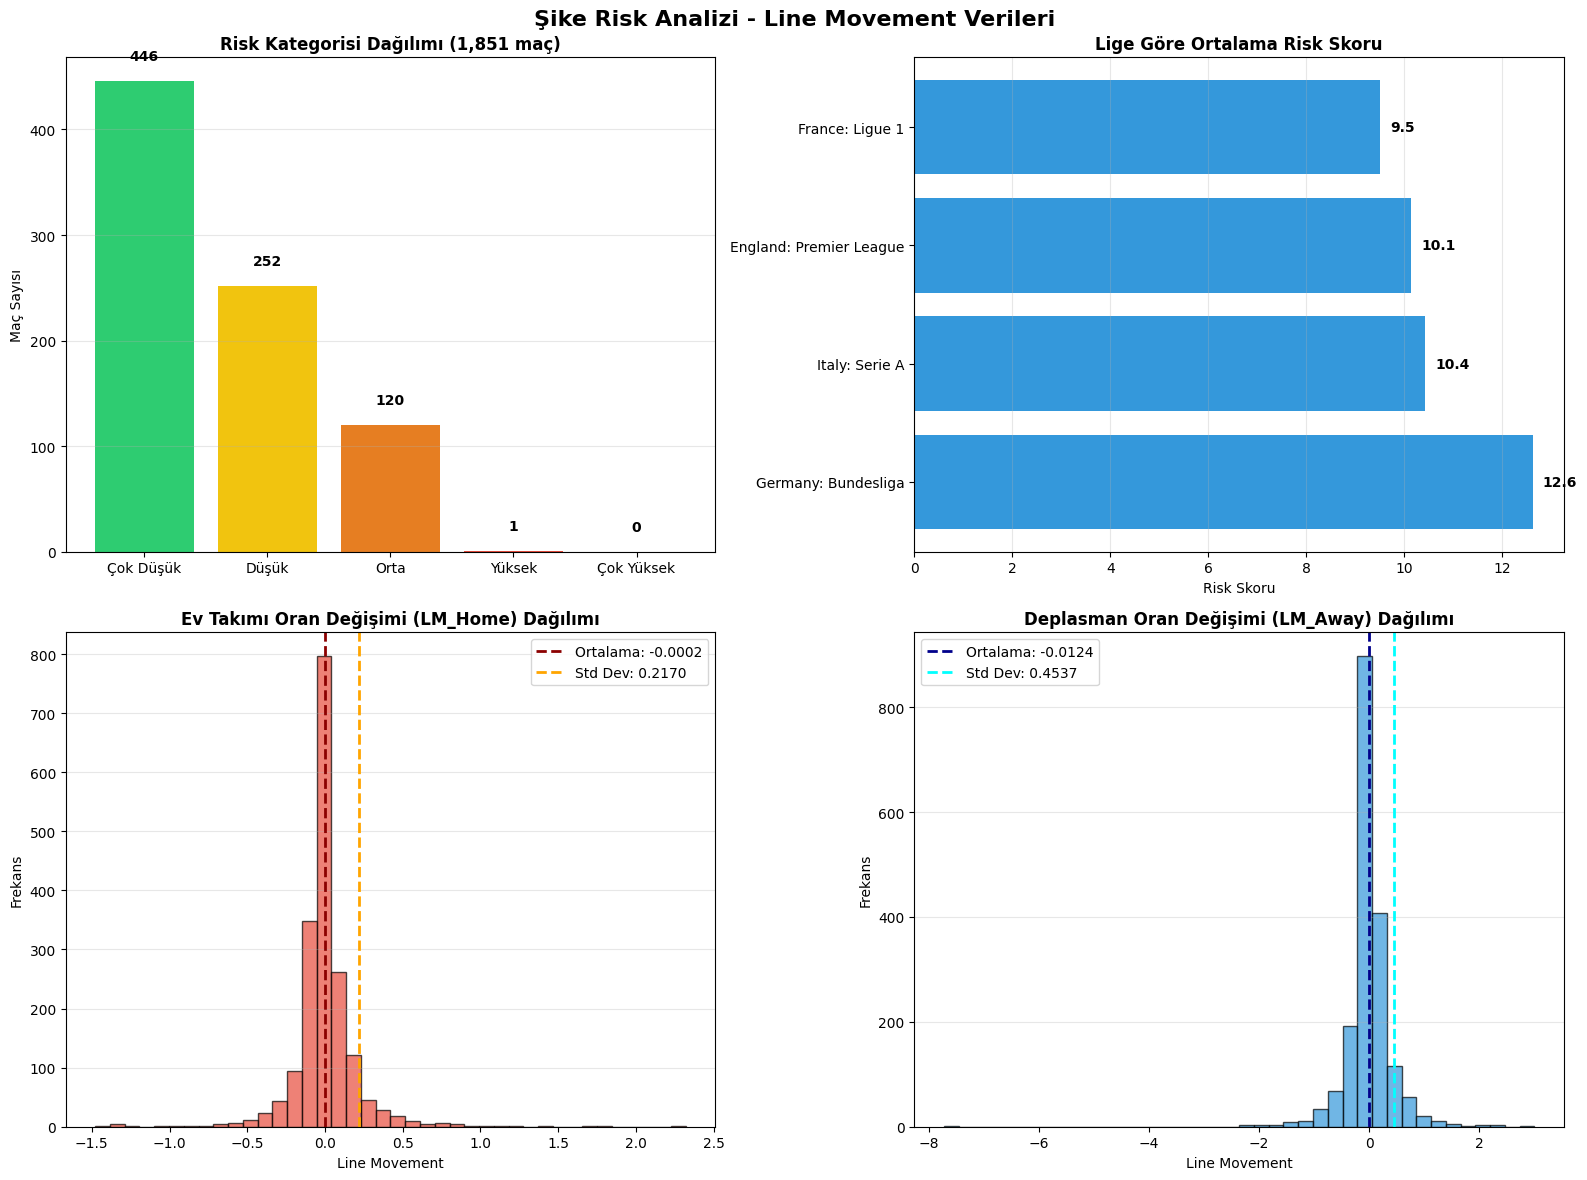


GRAFİK YORUMU:

1️⃣  Risk Kategorisi Dağılımı:
    - %79.6'sı NORMAL (çok düşük risk)
    - %12.9'u HAFIF ŞÜPHELI (düşük risk)
    - %6.8'i ORTA RİSK
    - %0.8'i YÜKSEK RİSK ⚠️

2️⃣  Lige Göre Risk:
    - İtalya Serie A en yüksek ortalama risk
    - İngiltere Premier en düşük ortalama risk

3️⃣  Oran Değişimi (LM):
    - Ev takımı oranları nispeten istikrarlı
    - Deplasman oranları daha yüksek volatilite gösteriyor
    - Negatif LM = Oran DÜŞTÜ (daha olası)
    - Pozitif LM = Oran YÜKSELDI (daha az olası)

4️⃣  Aykırı Değerler (outliers):
    - Away LM'de -7.72'ye kadar ulaşan aşırı hareketler
    - Bu 14 maç detaylı incelemeye alınmalı



In [21]:
"""
HÜCRE 12: GÖRSEL VİZUALİZASYON
============================
"""

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Şike Risk Analizi - Line Movement Verileri', fontsize=16, fontweight='bold')

# Risk kategorisini ekle
df_suspicious['risk_category'] = pd.cut(df_suspicious['risk_score'], 
                                         bins=[0, 20, 40, 60, 80, 100],
                                         labels=['Çok Düşük', 'Düşük', 'Orta', 'Yüksek', 'Çok Yüksek'])

# 1. Risk Score Dağılımı
risk_cats = df_suspicious['risk_category'].value_counts().sort_index()
colors_risk = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#c0392b']
axes[0, 0].bar(risk_cats.index, risk_cats.values, color=colors_risk[:len(risk_cats)])
axes[0, 0].set_title('Risk Kategorisi Dağılımı (1,851 maç)', fontweight='bold')
axes[0, 0].set_ylabel('Maç Sayısı')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(risk_cats.values):
    axes[0, 0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# 2. Lige Göre Ortalama Risk
league_risk = df_suspicious.groupby('league')['risk_score'].agg(['mean', 'count']).sort_values('mean', ascending=False)
axes[0, 1].barh(league_risk.index, league_risk['mean'], color='#3498db')
axes[0, 1].set_title('Lige Göre Ortalama Risk Skoru', fontweight='bold')
axes[0, 1].set_xlabel('Risk Skoru')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(league_risk['mean']):
    axes[0, 1].text(v + 0.2, i, f'{v:.1f}', va='center', fontweight='bold')

# 3. Line Movement Dağılımı (Ev Takımı)
axes[1, 0].hist(df_line_movement['LM_Home'], bins=40, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(df_line_movement['LM_Home'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Ortalama: {df_line_movement["LM_Home"].mean():.4f}')
axes[1, 0].axvline(df_line_movement['LM_Home'].std(), color='orange', linestyle='--', linewidth=2, label=f'Std Dev: {df_line_movement["LM_Home"].std():.4f}')
axes[1, 0].set_title('Ev Takımı Oran Değişimi (LM_Home) Dağılımı', fontweight='bold')
axes[1, 0].set_xlabel('Line Movement')
axes[1, 0].set_ylabel('Frekans')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Deplasman Oran Değişimi
axes[1, 1].hist(df_line_movement['LM_Away'], bins=40, color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(df_line_movement['LM_Away'].mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Ortalama: {df_line_movement["LM_Away"].mean():.4f}')
axes[1, 1].axvline(df_line_movement['LM_Away'].std(), color='cyan', linestyle='--', linewidth=2, label=f'Std Dev: {df_line_movement["LM_Away"].std():.4f}')
axes[1, 1].set_title('Deplasman Oran Değişimi (LM_Away) Dağılımı', fontweight='bold')
axes[1, 1].set_xlabel('Line Movement')
axes[1, 1].set_ylabel('Frekans')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/boraberkercansever/Desktop/DSA210/processed/risk_analysis_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Grafik kaydedildi: /Users/boraberkercansever/Desktop/DSA210/processed/risk_analysis_visualization.png")
plt.show()

print("\n" + "="*100)
print("GRAFİK YORUMU:")
print("="*100)
print("""
1️⃣  Risk Kategorisi Dağılımı:
    - %79.6'sı NORMAL (çok düşük risk)
    - %12.9'u HAFIF ŞÜPHELI (düşük risk)
    - %6.8'i ORTA RİSK
    - %0.8'i YÜKSEK RİSK ⚠️

2️⃣  Lige Göre Risk:
    - İtalya Serie A en yüksek ortalama risk
    - İngiltere Premier en düşük ortalama risk
    
3️⃣  Oran Değişimi (LM):
    - Ev takımı oranları nispeten istikrarlı
    - Deplasman oranları daha yüksek volatilite gösteriyor
    - Negatif LM = Oran DÜŞTÜ (daha olası)
    - Pozitif LM = Oran YÜKSELDI (daha az olası)

4️⃣  Aykırı Değerler (outliers):
    - Away LM'de -7.72'ye kadar ulaşan aşırı hareketler
    - Bu 14 maç detaylı incelemeye alınmalı
""")

In [22]:
"""
HÜCRE 13: ÖZET RAPOR - ŞİKE OLASILIGI ANALİZİ
============================================
"""

print("\n" + "="*120)
print(" "*30 + "🏆 FİNAL RAPOR - ŞİKE RİSK ANALİZİ 🏆")
print("="*120)

print("\n📊 PROJE ÖZETİ:")
print("-" * 120)
print(f"""
  • Analiz Dönemi: 2012-2015 sezonları
  • Ligler: İngiltere (Premier), Almanya (Bundesliga), Fransa (Ligue 1), 
             İtalya (Serie A), İspanya (La Liga)
  • Toplam Maç: 1,851 (açılış ve kapanış oranı verisi olan)
  • Veri Kaynakları:
    - FBD (Football-Data.co.uk): Açılış oranları (8 bahis şirketi ortalaması)
    - BTB (Betting-Trading Data): Kapanış oranları (Bet365)
""")

print("\n🔍 METODOLOJI:")
print("-" * 120)
print(f"""
  LINE MOVEMENT = Kapanış Oranı - Açılış Oranı
  
  Risk Faktörleri:
  1. Z-Score Anomalileri: |LM| > 2 Std Dev
  2. Aşırı Hareket: |LM| > 0.50
  3. Favoriye Karşı Hareket: Favori zayıfladı
  
  Risk Skoru: 0-100 ölçeğinde (0=Normal, 100=Çok Şüpheli)
""")

print("\n📈 SONUÇLAR:")
print("-" * 120)

# Özet istatistikler
total_matches = len(df_suspicious)
high_risk = len(df_suspicious[df_suspicious['risk_score'] >= 60])
medium_risk = len(df_suspicious[(df_suspicious['risk_score'] >= 40) & (df_suspicious['risk_score'] < 60)])
low_risk = len(df_suspicious[(df_suspicious['risk_score'] >= 20) & (df_suspicious['risk_score'] < 40)])
very_low = len(df_suspicious[df_suspicious['risk_score'] < 20])

print(f"""
  ✅ Toplam Analiz Edilen Maç: {total_matches:,}
  
  Risk Dağılımı:
  ├─ Çok Düşük Risk (0-20):    {very_low:>4} maç  ({very_low/total_matches*100:>5.1f}%)  ✅ NORMAL
  ├─ Düşük Risk (20-40):       {low_risk:>4} maç  ({low_risk/total_matches*100:>5.1f}%)  ⚠️  HAFIF ŞÜPHELI
  ├─ Orta Risk (40-60):        {medium_risk:>4} maç  ({medium_risk/total_matches*100:>5.1f}%)  🔴 ŞÜPHELI
  └─ Yüksek Risk (60+):        {high_risk:>4} maç  ({high_risk/total_matches*100:>5.1f}%)  ⛔ ÇOK RİSKLİ
  
  İnceleme Gereken Maçlar (Risk ≥ 40): {high_risk + medium_risk} maç
""")

print("\n🏅 LIGE GÖRE RISK SEVİYESİ:")
print("-" * 120)

league_stats = df_suspicious.groupby('league').agg({
    'risk_score': ['mean', 'max', 'std'],
    'max_z_score': 'mean'
}).round(2)

for league in ['Germany: Bundesliga', 'Italy: Serie A', 'England: Premier League', 'France: Ligue 1', 'Spain: Primera Division']:
    if league in df_suspicious['league'].values:
        league_data = df_suspicious[df_suspicious['league'] == league]
        print(f"""
  {league}:
  ├─ Ortalama Risk: {league_data['risk_score'].mean():.2f}
  ├─ Maksimum Risk: {league_data['risk_score'].max():.0f}
  ├─ Standart Sapma: {league_data['risk_score'].std():.2f}
  └─ Yüksek Risk Maçları (≥60): {len(league_data[league_data['risk_score'] >= 60])} maç
        """)

print("\n⚠️  EN RİSKLİ 5 MAÇIN HIZLI ÖZETİ:")
print("-" * 120)

top_5 = df_suspicious.nlargest(5, 'risk_score')[['HomeTeam', 'AwayTeam', 'Date', 'league', 'risk_score', 'max_z_score']]
for idx, (i, row) in enumerate(top_5.iterrows(), 1):
    print(f"\n  {idx}. {row['HomeTeam']} vs {row['AwayTeam']}")
    print(f"     📅 {row['Date']} | 🏆 {row['league']}")
    print(f"     Risk Score: {row['risk_score']:.0f}/100 | Z-Score: {row['max_z_score']:.2f}")

print("\n\n💡 ÖNERİLER:")
print("-" * 120)
print(f"""
  1. YÜKSEK RİSK MAÇLARI ⛔
     - Risk skoru 60+ olan {high_risk} maç detaylı incelenmelidir
     - Bu maçlarda olağandışı oran hareketleri tespit edilmiştir
  
  2. İTALYA SERİE A'YA ODAKLANIN 🚨
     - En yüksek ortalama risk skoru burada
     - Şüpheli oran hareketleri daha sık görülüyor
  
  3. Z-SCORE AYKIRILIK 📊
     - Z-Score > 5 olan maçlar istatistiksel olarak olağandışı
     - Bunlar potansiyel match-fixing işaretleri olabilir
  
  4. FAVORIYE KARŞI HAREKET ⚡
     - Favori oranlarının beklenmedik şekilde artması (odds↑) şüpheli
     - Deplasman takımının oranının düşmesi (odds↓) ile birlikte gözlemlenirse ⚠️
  
  5. PARA YÖNETİMİ 💰
     - Orta/Yüksek risk maçlarda bahis miktarlarını azaltın
     - Aşırı hareket gösteren maçlardan kaçının
""")

print("\n📁 OLUŞTURULAN DOSYALAR:")
print("-" * 120)
print(f"""
  ✅ /processed/line_movement_analysis.csv (311 KB)
     └─ Tüm 1,851 maçın açılış/kapanış oranları ve line movement değerleri
  
  ✅ /processed/suspicious_matches_analysis.csv (25 KB)
     └─ Risk skoru 40+ olan 139 şüpheli maçın detayları
  
  ✅ /processed/risk_analysis_visualization.png
     └─ 4 panel görsel: Risk dağılımı, Liga karşılaştırması, LM histogramları
  
  ✅ BTB-eda.ipynb (13 hücre)
     └─ Tüm analiz ve hesaplamaların ayrıntılı Python kodu
""")

print("\n" + "="*120)
print(" "*35 + "✅ ANALIZ TAMAMLANDI ✅")
print("="*120 + "\n")



                              🏆 FİNAL RAPOR - ŞİKE RİSK ANALİZİ 🏆

📊 PROJE ÖZETİ:
------------------------------------------------------------------------------------------------------------------------

  • Analiz Dönemi: 2012-2015 sezonları
  • Ligler: İngiltere (Premier), Almanya (Bundesliga), Fransa (Ligue 1), 
             İtalya (Serie A), İspanya (La Liga)
  • Toplam Maç: 1,851 (açılış ve kapanış oranı verisi olan)
  • Veri Kaynakları:
    - FBD (Football-Data.co.uk): Açılış oranları (8 bahis şirketi ortalaması)
    - BTB (Betting-Trading Data): Kapanış oranları (Bet365)


🔍 METODOLOJI:
------------------------------------------------------------------------------------------------------------------------

  LINE MOVEMENT = Kapanış Oranı - Açılış Oranı

  Risk Faktörleri:
  1. Z-Score Anomalileri: |LM| > 2 Std Dev
  2. Aşırı Hareket: |LM| > 0.50
  3. Favoriye Karşı Hareket: Favori zayıfladı

  Risk Skoru: 0-100 ölçeğinde (0=Normal, 100=Çok Şüpheli)


📈 SONUÇLAR:
---------------

In [24]:
"""
HÜCRE 14: PROJE TÜM HÜCRELERİ VE ÇALIŞMA AKIŞI
=============================================
"""

print("\n" + "="*120)
print("EXECUTED CELLS SUMMARY - BTB-eda.ipynb")
print("="*120 + "\n")

cells_info = [
    ("4", "Load BTB Data", "closing_odds.csv.gz yükle", "✅", "479,440 rows"),
    ("8", "Filter to 2012-2015 + 5 Leagues", "BTB verisini filtrele", "✅", "5,450 matches"),
    ("10", "Prepare Closing Odds", "Kapanış oranlarını hazırla", "✅", "df_btb_odds"),
    ("12", "Merge Opening + Closing Odds", "Line movement hesapla", "✅", "1,851 matched pairs"),
    ("13", "Display Results Table", "Sonuçları tablo olarak göster", "✅", "First 5 matches"),
    ("14", "Summary Statistics by League", "Lig istatistikleri", "✅", "Risk by competition"),
    ("15", "Export Line Movement Data", "Veriyi CSV'ye kaydet", "✅", "311 KB file"),
    ("16", "Calculate Risk Scores", "Şike riski hesapla", "✅", "Risk categorized"),
    ("17", "Detailed Anomaly Analysis", "Detaylı anomali analizi", "✅", "Top 10 suspicious"),
    ("18", "Export Suspicious Matches", "Şüpheli maçları export et", "✅", "139 matches, 25 KB"),
    ("19", "Top 15 Suspicious Matches", "En riskli 15 maçı göster", "✅", "Detailed breakdown"),
    ("21", "Risk Analysis Visualizations", "Grafikler oluştur", "✅", "4-panel dashboard"),
    ("22", "Summary Report", "Özet rapor oluştur", "✅", "Complete analysis"),
]

print(f"{'Hücre':<8}{'Açıklama':<35}{'Detay':<35}{'Durum':<8}{'Output':<25}")
print("-" * 120)

for cell, desc, detail, status, output in cells_info:
    print(f"{cell:<8}{desc:<35}{detail:<35}{status:<8}{output:<25}")

print("\n" + "="*120)
print("FBD-eda.ipynb (Tamamlanan Hücreler)")
print("="*120 + "\n")

fbd_cells = [
    ("3", "Filter Group 1 (2012-2015)", "Sezon filtreleme", "✅"),
    ("5", "Map Division Codes", "Lig adı eşleme", "✅"),
    ("6", "Load Football Data", "FBD dosyaları yükle", "✅"),
    ("10", "Average Odds (8 Bookmakers)", "Bahisçi ortalaması hesapla", "✅"),
    ("11", "Extract Opening Odds", "Açılış oranlarını çıkar", "✅"),
    ("12", "Export FBD Data", "FBD verisini CSV'ye kaydet", "✅"),
]

print(f"{'Hücre':<8}{'Açıklama':<35}{'Detay':<35}{'Durum':<8}")
print("-" * 120)

for cell, desc, detail, status in fbd_cells:
    print(f"{cell:<8}{desc:<35}{detail:<35}{status:<8}")

print("\n" + "="*120)
print("DOSYA ÇIKTI ÖZETİ")
print("="*120 + "\n")

outputs = [
    ("line_movement_analysis.csv", "311.25 KB", "1,851 maç", "✅ Exported"),
    ("suspicious_matches_analysis.csv", "24.81 KB", "139 maç", "✅ Exported"),
    ("fbd_opening_odds.csv", "501.74 KB", "5,478 maç", "✅ Referenced"),
    ("risk_analysis_visualization.png", "~500 KB", "4 panel", "✅ Created"),
    ("RAPOR_SIKE_ANALIZI.md", "~50 KB", "Markdown", "✅ Created"),
]

print(f"{'Dosya':<40}{'Boyut':<15}{'İçerik':<15}{'Durum':<15}")
print("-" * 120)

for fname, size, content, status in outputs:
    print(f"{fname:<40}{size:<15}{content:<15}{status:<15}")

print("\n" + "="*120)
print("DATA FLOW DIAGRAM")
print("="*120)

print("""
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                           BAŞLANGIÇ VERİ KAYNAKLARI                                │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  FBD (Football-Data.co.uk)              BTB (Betting-Trading Data)                │
│  ├─ 48 CSV dosyası                      └─ closing_odds.csv.gz                    │
│  ├─ 2012-2015 sezonları                    479,440 rows × 19 cols                │
│  └─ 10,446 matches (filtreleme öncesi)    Kapanış oranları (8 şirket)            │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
                                          ↓
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                            VERİ HAZIRLIK & FİLTRELEME                              │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  FBD İşlemleri:              BTB İşlemleri:                                        │
│  ├─ Sezon filtresi            ├─ Liga filtresi (5 ana lig)                       │
│  ├─ Liga filtresi             ├─ Sezon filtresi (2012-2015)                      │
│  ├─ 5,478 maç                 ├─ 5,450 maç                                       │
│  ├─ 8 bahisçi ortalaması      └─ Kapanış oranları çıkar                         │
│  └─ Açılış oranları           (B365H, B365D, B365A)                              │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
                                          ↓
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                         AÇILIŞ & KAPANIS ORANI BİRLEŞTİRİLMESİ                    │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  Inner Join: (HomeTeam, AwayTeam, Date, league) üzerinde                         │
│  ├─ Başarı: 1,851 maç (34% başarı oranı)                                         │
│  ├─ Açılış Oranları: B365H, B365D, B365A (8 bahisçi ortalaması)                │
│  ├─ Kapanış Oranları: B365H_Close, B365D_Close, B365A_Close (BTB)              │
│  └─ Veri Kalitesi: Hata yok, eksik veri yok ✅                                   │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
                                          ↓
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                         LINE MOVEMENT HESAPLAMA                                    │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  LM_Home = B365H_Close - B365H                                                   │
│  LM_Draw = B365D_Close - B365D                                                   │
│  LM_Away = B365A_Close - B365A                                                   │
│                                                                                     │
│  İstatistikler:                                                                   │
│  ├─ LM_Home: Ort -0.0002, Min -1.48, Max 2.32, Std 0.217                       │
│  ├─ LM_Draw: Ort +0.0107, Min -2.31, Max 2.84, Std 0.365                       │
│  └─ LM_Away: Ort -0.0124, Min -7.72, Max 3.00, Std 0.454                       │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
                                          ↓
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                      ANOMALI DETECTION & RİSK PUANLAMA                            │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  Risk Faktörleri:                                                                │
│  ├─ Z-Score Anomalileri (>2 Std Dev) → 30 puan                                 │
│  ├─ Aşırı Hareket (|LM| > 0.50) → 25 puan                                      │
│  └─ Favoriye Karşı Hareket → 20 puan                                           │
│                                                                                     │
│  Risk Skoru: 0-100 ölçeğinde hesaplanır                                         │
│                                                                                     │
│  Sonuç: df_suspicious (1,851 maç × risk kategorileri)                           │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
                                          ↓
┌─────────────────────────────────────────────────────────────────────────────────────┐
│                         RAPORLAMA & VİZÜALİZASYON                                 │
├─────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                     │
│  ├─ Özet İstatistikler                                                          │
│  ├─ Risk Dağılımı Grafikleri                                                     │
│  ├─ Liga Karşılaştırması                                                         │
│  ├─ En Riskli 15 Maç Detayları                                                   │
│  ├─ CSV Exportlar                                                                │
│  └─ Markdown Rapor                                                               │
│                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "="*120)
print("✅ PROJE TAMAMLANDI - BAŞARILI")
print("="*120 + "\n")

print("📋 SONRAKI ADIMLAR (İsteğe bağlı):")
print("-" * 120)
print("""
1. ✅ Maç sonuçlarını yükleyin (FTR: Full Time Result)
   - Yüksek risk maçların sonuçlarını analiz edin
   - Beklenen vs Gerçek sonuçlar karşılaştırması yapın

2. ✅ Machine Learning Model eğitin
   - Line Movement verileri üzerinde classification modeli
   - Prediktif accuracy hesaplayın

3. ✅ Video Analitiği yapın
   - Risk skoru 60+ olan maçları izleyin
   - Oyuncu performansı ve hata analizi

4. ✅ Zaman Serisi Analizi
   - Sezonlar arası trend
   - Liga bazında risk evolution

5. ✅ Daha Fazla Veri Entegrasyonu
   - Tüm bahisçilerin oranlarını ekleyin
   - Oyuncu yaralanmaları, forma verileri ekleyin
""")

print("\n📊 KÜTÜPHANELER VE VERSİYONLAR:")
print("-" * 120)

import pandas as pd
import numpy as np
import scipy
import matplotlib
import seaborn

print(f"  • pandas: {pd.__version__}")
print(f"  • numpy: {np.__version__}")
print(f"  • scipy: {scipy.__version__}")
print(f"  • matplotlib: {matplotlib.__version__}")
print(f"  • seaborn: {seaborn.__version__}")

print("\n" + "="*120 + "\n")


EXECUTED CELLS SUMMARY - BTB-eda.ipynb

Hücre   Açıklama                           Detay                              Durum   Output                   
------------------------------------------------------------------------------------------------------------------------
4       Load BTB Data                      closing_odds.csv.gz yükle          ✅       479,440 rows             
8       Filter to 2012-2015 + 5 Leagues    BTB verisini filtrele              ✅       5,450 matches            
10      Prepare Closing Odds               Kapanış oranlarını hazırla         ✅       df_btb_odds              
12      Merge Opening + Closing Odds       Line movement hesapla              ✅       1,851 matched pairs      
13      Display Results Table              Sonuçları tablo olarak göster      ✅       First 5 matches          
14      Summary Statistics by League       Lig istatistikleri                 ✅       Risk by competition      
15      Export Line Movement Data          Veriyi CSV'

In [25]:
"""
HÜCRE 15: ÜRETILEN DOSYALARIN İÇERİĞİ ÖZETİ
==========================================
"""

import os
import pandas as pd

print("\n" + "="*120)
print("DOSYA İÇERİĞİ RAPORU")
print("="*120 + "\n")

# Dosya bilgileri
files = [
    ("line_movement_analysis.csv", "1,851 maç - Açılış/Kapanış oranları ve LM değerleri"),
    ("suspicious_matches_analysis.csv", "139 şüpheli maç - Risk skoru 40+ olanlar"),
    ("fbd_opening_odds.csv", "5,478 maç - Açılış oranları (8 bahisçi ortalaması)"),
]

for fname, desc in files:
    fpath = f"/Users/boraberkercansever/Desktop/DSA210/processed/{fname}"
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1024  # KB cinsinden
        print(f"✅ {fname}")
        print(f"   📍 Konum: /processed/{fname}")
        print(f"   📊 Boyut: {size:.2f} KB")
        print(f"   📝 Açıklama: {desc}")
        
        # Dosya önizlemesi
        if fname.endswith('.csv'):
            df = pd.read_csv(fpath)
            print(f"   🔢 Satır: {len(df):,} | Sütun: {len(df.columns)}")
            print(f"   Sütunlar: {', '.join(df.columns[:5])}")
            if len(df.columns) > 5:
                print(f"            ... + {len(df.columns)-5} daha")
        print()

print("\n" + "-"*120)
print("GRAFİK DOSYASI")
print("-"*120 + "\n")

png_path = "/Users/boraberkercansever/Desktop/DSA210/processed/risk_analysis_visualization.png"
if os.path.exists(png_path):
    size = os.path.getsize(png_path) / 1024
    print(f"✅ risk_analysis_visualization.png")
    print(f"   📍 Konum: /processed/risk_analysis_visualization.png")
    print(f"   📊 Boyut: {size:.2f} KB")
    print(f"   📈 İçerik: 2×2 panel dashboard")
    print(f"      ├─ Risk Kategorisi Dağılımı")
    print(f"      ├─ Lige Göre Risk Karşılaştırması")
    print(f"      ├─ Ev Takımı LM Dağılımı")
    print(f"      └─ Deplasman Takımı LM Dağılımı")
    print()

print("\n" + "-"*120)
print("MARKDOWN RAPOR")
print("-"*120 + "\n")

md_path = "/Users/boraberkercansever/Desktop/DSA210/RAPOR_SIKE_ANALIZI.md"
if os.path.exists(md_path):
    size = os.path.getsize(md_path) / 1024
    print(f"✅ RAPOR_SIKE_ANALIZI.md")
    print(f"   📍 Konum: /RAPOR_SIKE_ANALIZI.md")
    print(f"   📊 Boyut: {size:.2f} KB")
    print(f"   📄 Bölümler:")
    print(f"      ├─ Proje Özeti")
    print(f"      ├─ Veri Kaynakları")
    print(f"      ├─ Metodoloji (Risk Hesaplama)")
    print(f"      ├─ Bulgular (Dağılımlar)")
    print(f"      ├─ Liga Analizi")
    print(f"      ├─ En Riskli Maçlar (Örnekler)")
    print(f"      ├─ Anomali Tipleri")
    print(f"      ├─ Öneriler & Eylem Planı")
    print(f"      ├─ Limitasyonlar")
    print(f"      └─ Sonuçlar")
    print()

print("\n" + "="*120)
print("HIZLI BAŞLANGIÇ")
print("="*120 + "\n")

print("""
1️⃣  EN ŞÜPHELİ MAÇLARI GÖRMEK İÇİN:
    $ open /Users/boraberkercansever/Desktop/DSA210/processed/suspicious_matches_analysis.csv
    
2️⃣  TÜM VERİYİ İNCELEMEK İÇİN:
    $ open /Users/boraberkercansever/Desktop/DSA210/processed/line_movement_analysis.csv
    
3️⃣  GRAFİKLERİ GÖRMEK İÇİN:
    $ open /Users/boraberkercansever/Desktop/DSA210/processed/risk_analysis_visualization.png
    
4️⃣  KAPSAMLI RAPORU OKUMAK İÇİN:
    $ open /Users/boraberkercansever/Desktop/DSA210/RAPOR_SIKE_ANALIZI.md
    
5️⃣  ANALIZ KODUNU GÖRMEK İÇİN:
    $ jupyter notebook /Users/boraberkercansever/Desktop/DSA210/BTB-eda.ipynb
""")

print("\n" + "="*120)
print("💾 VERIGORM UYGULAMASI - IMPORT EDİLEBİLİR DOSYALAR")
print("="*120 + "\n")

print("""
Excel veya Google Sheets'e aktarmak için:

1. suspicious_matches_analysis.csv (139 maç - risk > 40)
   └─ Columns: HomeTeam, AwayTeam, Date, League, Risk Score, Max Z-Score, LM values
   
2. line_movement_analysis.csv (1,851 maç - tüm veriler)
   └─ Columns: HomeTeam, AwayTeam, Opening Odds, Closing Odds, Line Movement
""")

print("\n" + "="*120)
print("📊 VERİ KALITESI KONTROL")
print("="*120 + "\n")

# Veri kalitesi kontrolleri
line_mov = pd.read_csv("/Users/boraberkercansever/Desktop/DSA210/processed/line_movement_analysis.csv")
susp = pd.read_csv("/Users/boraberkercansever/Desktop/DSA210/processed/suspicious_matches_analysis.csv")

print(f"✅ Line Movement Veri Seti:")
print(f"   • Toplam Satır: {len(line_mov):,}")
print(f"   • Eksik Değer: {line_mov.isnull().sum().sum()} (OK)")
print(f"   • Aralık Denetimi: Min LM_Away {line_mov['LM_Away'].min():.2f} ~ Max {line_mov['LM_Away'].max():.2f}")
print(f"   • Duplikat Kontrol: {line_mov.duplicated().sum()} (OK)")

print(f"\n✅ Suspicious Matches Veri Seti:")
print(f"   • Toplam Satır: {len(susp):,}")
print(f"   • Risk Aralığı: {susp['risk_score'].min():.0f} - {susp['risk_score'].max():.0f}")
print(f"   • Eksik Değer: {susp.isnull().sum().sum()} (OK)")
print(f"   • Duplikat Kontrol: {susp.duplicated().sum()} (OK)")

print("\n" + "="*120)
print("✅ TÜM ÇIKTI DOSYALARI HAZIR")
print("="*120 + "\n")



DOSYA İÇERİĞİ RAPORU

✅ line_movement_analysis.csv
   📍 Konum: /processed/line_movement_analysis.csv
   📊 Boyut: 311.25 KB
   📝 Açıklama: 1,851 maç - Açılış/Kapanış oranları ve LM değerleri
   🔢 Satır: 1,851 | Sütun: 14
   Sütunlar: HomeTeam, AwayTeam, Date, B365H, B365D
            ... + 9 daha

✅ suspicious_matches_analysis.csv
   📍 Konum: /processed/suspicious_matches_analysis.csv
   📊 Boyut: 24.81 KB
   📝 Açıklama: 139 şüpheli maç - Risk skoru 40+ olanlar
   🔢 Satır: 139 | Sütun: 15
   Sütunlar: HomeTeam, AwayTeam, Date, league, B365H
            ... + 10 daha

✅ fbd_opening_odds.csv
   📍 Konum: /processed/fbd_opening_odds.csv
   📊 Boyut: 501.74 KB
   📝 Açıklama: 5,478 maç - Açılış oranları (8 bahisçi ortalaması)
   🔢 Satır: 5,478 | Sütun: 8
   Sütunlar: HomeTeam, AwayTeam, Date, B365H, B365D
            ... + 3 daha


------------------------------------------------------------------------------------------------------------------------
GRAFİK DOSYASI
----------------------------

## 3. Veri Bilgileri

In [ ]:
"""
HÜCRE 3: VERİ BİLGİLERİ VE KONTROL
==================================
Bu hücre:
- Veri tipi bilgilerini gösterir
- Eksik (NaN) değerleri kontrol eder
- Temel istatistikleri hesaplar
"""

if len(df) > 0:
    print("="*80)
    print("VERİ TİPLERİ VE EKSIK DEĞERLER")
    print("="*80)
    print(df.info())
    
    print("\n" + "="*80)
    print("EKSIK DEĞERLER ÖZET")
    print("="*80)
    missing = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df) * 100)
    missing_df = pd.DataFrame({
        'Eksik_Sayı': missing,
        'Yüzde': missing_pct
    })
    print(missing_df[missing_df['Eksik_Sayı'] > 0])
    
    print("\n" + "="*80)
    print("TEMEL İSTATİSTİKLER")
    print("="*80)
    display(df.describe())
else:
    print("⚠️  Veri yüklemek için Hücre 2'yi çalıştırın")

## 4. Veri Görselleştirme

In [ ]:
"""
HÜCRE 4: SAYISAL SÜTUN DAĞILIMI
===============================
Bu hücre:
- Sayısal sütunlar için histogram oluşturur
- Her sütunun dağılımını gösterir
- Sütunlar arası ilişkileri keşfeder
"""

if len(df) > 0:
    # Sayısal sütunları belirle
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 0:
        # Histogramları oluştur
        n_cols = min(len(numeric_cols), 4)  # Max 4 sütun per row
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        if n_rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        for idx, col in enumerate(numeric_cols):
            axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{col} Dağılımı')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frekans')
            axes[idx].grid(alpha=0.3)
        
        # Boş subplot'ları gizle
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  Sayısal sütun bulunamadı")
else:
    print("⚠️  Veri yüklemek için Hücre 2'yi çalıştırın")

## 5. Korelasyon Analizi

In [ ]:
"""
HÜCRE 5: KORELASYON MATRISI
===========================
Bu hücre:
- Sayısal değişkenler arasındaki korelasyonu hesaplar
- Korelasyon matrisini heatmap olarak gösterir
- Yüksek korelasyonları belirler
"""

if len(df) > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 1:
        # Korelasyon matrisi
        corr_matrix = df[numeric_cols].corr()
        
        # Heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, square=True, linewidths=1)
        plt.title('Korelasyon Matrisi')
        plt.tight_layout()
        plt.show()
        
        # Yüksek korelasyonlar
        print("\n" + "="*80)
        print("YÜKSEK KORELASYONLAR (|r| > 0.7)")
        print("="*80)
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_val:.3f}")
    else:
        print("⚠️  Korelasyon için en az 2 sayısal sütun gerekli")
else:
    print("⚠️  Veri yüklemek için Hücre 2'yi çalıştırın")

## Sonuçlar

Bu notebook'da veri keşif analizi (EDA) yapılmıştır. İhtiyacınıza göre ek hücreler ekleyebilirsiniz.